# Model

In [1]:
import torch_struct
import torch
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)

## Chain

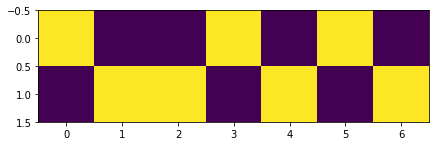

In [3]:
batch, N, C = 3, 7, 2
def show_chain(chain):
    plt.imshow(chain.detach().sum(-1).transpose(0, 1))

# batch, N, z_n, z_n_1
log_potentials = torch.rand(batch, N, C, C)
dist = torch_struct.LinearChainCRF(log_potentials)
show_chain(dist.argmax[0])

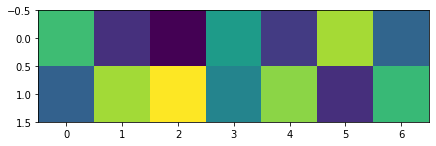

In [4]:
show_chain(dist.marginals[0])

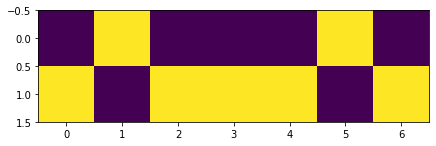

In [5]:
event = dist.to_event(torch.tensor([[0, 1, 0, 1, 1, 1, 0, 1]]), 2)
show_chain(event[0])

## Hidden Markov Model

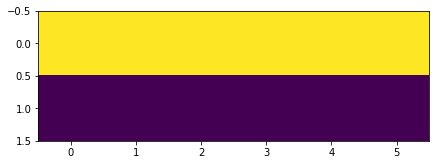

In [6]:
batch, V, N, C = 10, 3, 7, 2

transition = torch.rand(C, C).log_softmax(0)
emission = torch.rand(V, C).log_softmax(0)
init = torch.rand(C).log_softmax(0)
observations = torch.randint(0, V, size=(batch, N))

dist = torch_struct.HMM(transition, emission, init, observations)
show_chain(dist.argmax[0])

## Semi-Markov

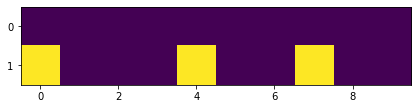

In [7]:
batch, N, C, K = 3, 10, 2, 6
def show_sm(chain):
    plt.imshow(chain.detach().sum(1).sum(-1).transpose(0, 1))

# batch, N, K, z_n, z_n_1
log_potentials = torch.rand(batch, N, K, C, C)
log_potentials[:, :, :3] = -1e9
dist = torch_struct.SemiMarkovCRF(log_potentials)
show_sm(dist.argmax[0])

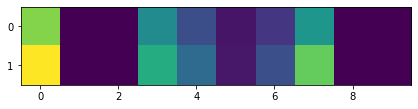

In [8]:
show_sm(dist.marginals[0])

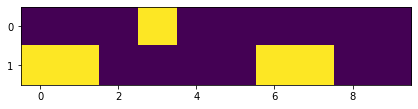

In [9]:
# Use -1 for segments.
event = dist.to_event(torch.tensor([[0, 1, -1, 1, -1, -1, 0, 1,  1, -1, -1]]), (2, 6))
show_sm(event[0])

## Alignment

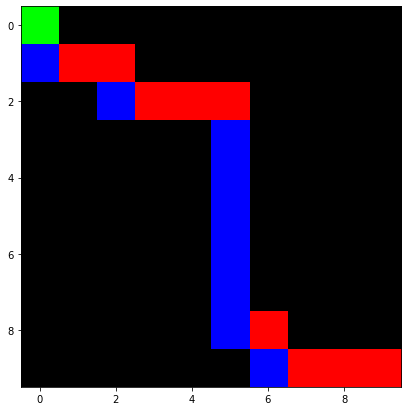

In [12]:
batch, N, M = 3, 10, 10
def show_deps(tree):
    plt.imshow(tree.detach())

log_potentials = torch.rand(batch, N, M, 3)
dist = torch_struct.AlignmentCRF(log_potentials)
show_deps(dist.argmax[0])

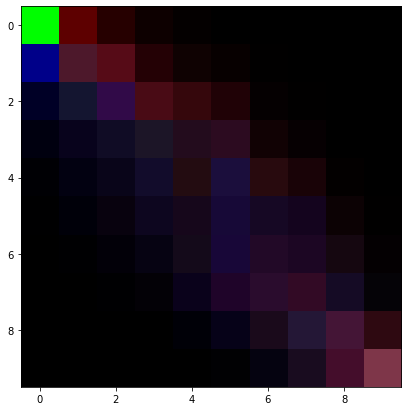

In [13]:
show_deps(dist.marginals[0])

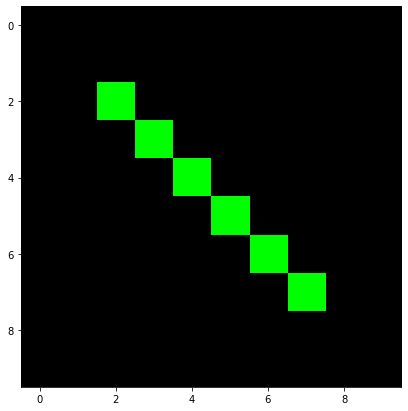

In [30]:
log_potentials = torch.rand(batch, N, M, 3)

# Local values must be postive for match and negative for skip.
log_potentials[..., 0] = -log_potentials[..., 0].abs()
log_potentials[..., 1] = log_potentials[..., 1].abs()
log_potentials[..., 2] = -log_potentials[..., 2].abs()

# Block off top rows and columns
log_potentials[..., :2, :, 1] = 0
log_potentials[..., :, :2, 1] = 0
log_potentials[..., -2:, :, 1] = 0
log_potentials[..., :, -2:, 1] = 0

dist = torch_struct.AlignmentCRF(log_potentials, local=True)
show_deps(dist.argmax[0])

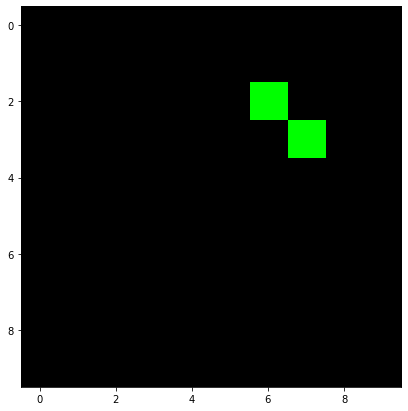

In [34]:
log_potentials[..., 3, 7, 1] = 50
dist = torch_struct.AlignmentCRF(log_potentials, local=True)
show_deps(dist.argmax[0])

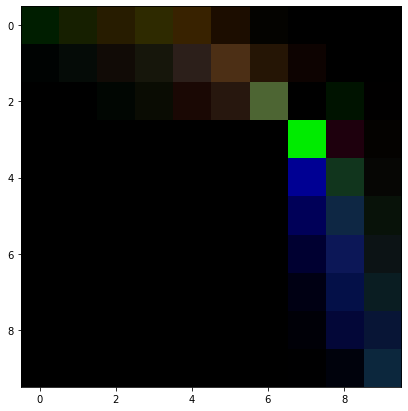

In [35]:
show_deps(dist.marginals[0])

## Dependency Tree

In [ ]:
batch, N, N = 3, 10, 10
def show_deps(tree):
    plt.imshow(tree.detach())

log_potentials = torch.rand(batch, N, N)
dist = torch_struct.DependencyCRF(log_potentials)
show_deps(dist.argmax[0])

In [ ]:
show_deps(dist.marginals[0])

In [ ]:
# Convert from 1-index standard format. (Head is 0)
event = dist.to_event(torch.tensor([[2, 3, 4, 1, 0, 4]]), None)
show_deps(event[0])

## Non-Projective Dependency Tree

In [ ]:
batch, N, N = 3, 10, 10
def show_deps(tree):
    plt.imshow(tree.detach())

log_potentials = torch.rand(batch, N, N)
dist = torch_struct.NonProjectiveDependencyCRF(log_potentials)
show_deps(dist.marginals[0])

## Binary Labeled Tree

In [ ]:
batch, N, NT = 3, 20, 3
def show_tree(tree):
    t = tree.detach()
    plt.imshow(t[ :, : , 0] + 
               2 * t[ :,:, 1] +
               3 * t[ :,:, 2])

log_potentials = torch.rand(batch, N, N, NT)
dist = torch_struct.TreeCRF(log_potentials)
show_tree(dist.argmax[0])

In [ ]:
show_tree(dist.marginals[0])

## Probabilistic Context-Free Grammar

In [ ]:
batch, N, NT, T = 3, 20, 3, 3
def show_prob_tree(tree):
    t = tree.detach().sum(-1).sum(-1)
    plt.imshow(t[ :, : , 0] + 
               2 * t[ :,:, 1] +
               3 * t[ :,:, 2])

terminals = torch.rand(batch, N, T)
rules = torch.rand(batch, NT, NT+T,  NT+T)
init = torch.rand(batch, NT).log_softmax(-1)

dist = torch_struct.SentCFG((terminals, rules, init))
term, rules, init = dist.argmax

In [ ]:
# Rules
show_prob_tree(rules[0])

In [ ]:
# Terminals
plt.imshow(term[:1])

## Autoregressive / Beam Search

In [ ]:
batch, N, C, H, layer = 3, 10, 4, 5, 1
init = (torch.rand(batch, layer, H), 
        torch.rand(batch, layer, H))
def t(a):                                                                                                                                                                    
    return [t.transpose(0, 1) for t in a]

def show_ar(chain):
     plt.imshow(chain.detach().transpose(0, 1))

class RNN_AR(torch.nn.Module):                                                                                                                                                   
    def __init__(self):                                                                                                                                                      
        super().__init__()                                                                                                                                                   
        self.rnn = torch.nn.LSTM(H, H, batch_first=True)                                                                                                                     
        self.proj = torch.nn.Linear(H, C)                                                                                                                                    
        self.embed = torch.nn.Embedding(C, H)                                                                                                                                

    def forward(self, inputs, state):                                                                                                                                        
        inputs = self.embed(inputs)                                                                                                                                          
        out, state = self.rnn(inputs, t(state))
        return self.proj(out), t(state)
    
dist = torch_struct.Autoregressive(RNN_AR(), init, C, N)

In [ ]:
path = dist.greedy_argmax()
show_ar(path[0])

In [ ]:
dist.log_prob(path.unsqueeze(0))

In [ ]:
out = dist.beam_topk(5)[:, 0]
for i in range(3):
    show_ar(out[i])
    plt.show()

In [ ]:
out = dist.sample((5,))[:, 0 ]
print(out.shape)
for i in range(3):
    show_ar(out[i])
    plt.show()

In [ ]:
out = dist.sample_without_replacement((5,))[:, 0]
for i in range(3):
    show_ar(out[i])
    plt.show()

## Base Class

In [ ]:
batch, N, C = 3, 7, 2

# batch, N, z_n, z_n_1
log_potentials = torch.rand(batch, N, C, C)
dist = torch_struct.LinearChainCRF(log_potentials, lengths=torch.tensor([N-1, N, N+1]))
show_chain(dist.argmax[0])
plt.show()
show_chain(dist.argmax[1])

In [ ]:
show_chain(dist.marginals[0])
plt.show()
show_chain(dist.marginals[1])

In [ ]:
def show_samples(samples):
    show_chain(samples[0, 0])
    plt.show()
    show_chain(samples[1, 0])
    plt.show()
    show_chain(samples[0, 1])

In [ ]:
show_samples(dist.sample((10,)))

In [ ]:
show_samples(dist.topk(10))

In [ ]:
# Enumerate 
x,_ = dist.enumerate_support()
print(x.shape)
for i in range(10):
    show_chain(x[i][0])
    plt.show()

In [ ]:
plt.imshow(dist.entropy.detach().unsqueeze(0))